In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from pathlib import Path

In [2]:
current_dir = Path.cwd()

In [3]:
data_path = current_dir.parent.parent / 'Data_Processing' / 'merge' / 'df_alt2.csv'

In [5]:
df = pd.read_csv(data_path)

# Preprocessing

In [3]:
df.describe()

,day_precip,day_precipcover,day_snow,day_windspeed,day_winddir,day_uvindex,hour_temp,hour_humidity,hour_precip,hour_precipprob,...,Clear,Ice,Snow,Overcast,Rain,Fog,Partially cloudy,Freezing Drizzle/Freezing Rain,alarms,text_vector
count,608235.000000,608235.000000,608235.000000,608235.000000,608235.000000,608235.000000,608235.000000,608235.000000,608235.000000,608235.000000,...,608235.000000,608235.000000,608235.000000,608235.000000,608235.000000,608235.000000,608235.000000,608235.000000,608235.000000,595539.000000
mean,2.095817,6.553236,0.121145,18.545865,191.153775,4.804640,10.719585,72.889725,0.087358,6.553224,...,0.196802,0.000002,0.016964,0.404048,0.059679,0.000003,0.398369,0.000100,0.188133,0.009917
std,10.686203,12.103634,0.662885,6.887745,106.205077,2.653039,9.788004,19.456807,2.141677,24.746285,...,0.397582,0.001282,0.129136,0.490707,0.236892,0.001813,0.489563,0.010014,0.426658,0.001370
min,0.000000,0.000000,0.000000,2.500000,0.000000,0.000000,-50.300000,8.460000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,14.000000,98.200000,2.000000,2.400000,59.300000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009559
50%,0.100000,4.170000,0.000000,18.000000,195.600000,5.000000,10.200000,77.430000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010175
75%,1.092000,8.330000,0.000000,22.000000,287.000000,7.000000,18.400000,89.050000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.010763
max,306.000000,100.000000,16.100000,90.000000,360.000000,10.000000,60.400000,100.000000,300.000000,100.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,0.012344


In [4]:
df = df.fillna(0)

In [5]:
df.columns

Index(['city_address', 'day_precip', 'day_precipcover', 'day_snow',
       'day_windspeed', 'day_winddir', 'day_uvindex', 'day_sunrise',
       'day_sunset', 'hour_temp', 'hour_humidity', 'hour_precip',
       'hour_precipprob', 'hour_snow', 'hour_windspeed', 'hour_winddir',
       'hour_pressure', 'hour_visibility', 'hour_cloudcover', 'hour_uvindex',
       'datetime', 'Clear', 'Ice', 'Snow', 'Overcast', 'Rain', 'Fog',
       'Partially cloudy', 'Freezing Drizzle/Freezing Rain', 'anomaly',
       'alarms', 'date', 'text_vector'],
      dtype='object')

In [6]:
df['alarms'].value_counts()

alarms
0    502391
1     97523
2      8116
3       148
4        55
5         2
Name: count, dtype: int64

In [7]:
df['day_sunset']

0         17:51:06
1         17:51:06
2         17:51:06
3         17:51:06
4         17:51:06
            ...   
608230    17:24:37
608231    17:24:37
608232    17:24:37
608233    17:24:37
608234    17:24:37
Name: day_sunset, Length: 608235, dtype: object

In [8]:
df = df.drop(columns = ['anomaly', 'date'])

In [9]:
df['datetime']

0         2022-02-24 00:00:00
1         2022-02-24 01:00:00
2         2022-02-24 02:00:00
3         2022-02-24 03:00:00
4         2022-02-24 04:00:00
                 ...         
608230    2025-03-01 19:00:00
608231    2025-03-01 20:00:00
608232    2025-03-01 21:00:00
608233    2025-03-01 22:00:00
608234    2025-03-01 23:00:00
Name: datetime, Length: 608235, dtype: object

In [10]:
datetime_format = '%Y-%m-%d %H:%M:%S'
df['datetime'] = pd.to_datetime(df['datetime'], format=datetime_format, errors='coerce')
df['day_sunrise'] = pd.to_datetime(df['day_sunrise'], format='%H:%M:%S', errors='coerce')
df['day_sunset'] = pd.to_datetime(df['day_sunset'], format='%H:%M:%S', errors='coerce')

df['hour'] = df['datetime'].dt.hour
df['sunrise_hour'] = df['day_sunrise'].dt.hour
df['sunset_hour'] = df['day_sunset'].dt.hour


df['sun'] = ((df['hour'] >= df['sunrise_hour']) & (df['hour'] <= df['sunset_hour'])).astype(int)

df = df.drop(columns=['hour', 'sunrise_hour', 'sunset_hour'])

In [11]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

In [12]:
df = df.drop(columns = ['datetime', 'day_sunrise', 'day_sunset'])

In [13]:
df.columns

Index(['city_address', 'day_precip', 'day_precipcover', 'day_snow',
       'day_windspeed', 'day_winddir', 'day_uvindex', 'hour_temp',
       'hour_humidity', 'hour_precip', 'hour_precipprob', 'hour_snow',
       'hour_windspeed', 'hour_winddir', 'hour_pressure', 'hour_visibility',
       'hour_cloudcover', 'hour_uvindex', 'Clear', 'Ice', 'Snow', 'Overcast',
       'Rain', 'Fog', 'Partially cloudy', 'Freezing Drizzle/Freezing Rain',
       'alarms', 'text_vector', 'sun', 'year', 'month', 'day', 'hour',
       'minute', 'second'],
      dtype='object')

In [14]:
len(df.columns)

35

In [15]:
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_columns

Index(['day_precip', 'day_precipcover', 'day_snow', 'day_windspeed',
       'day_winddir', 'day_uvindex', 'hour_temp', 'hour_humidity',
       'hour_precip', 'hour_precipprob', 'hour_snow', 'hour_windspeed',
       'hour_winddir', 'hour_pressure', 'hour_visibility', 'hour_cloudcover',
       'hour_uvindex', 'Clear', 'Ice', 'Snow', 'Overcast', 'Rain', 'Fog',
       'Partially cloudy', 'Freezing Drizzle/Freezing Rain', 'alarms',
       'text_vector', 'sun', 'year', 'month', 'day', 'hour', 'minute',
       'second'],
      dtype='object')

In [16]:
len(numerical_columns)

34

In [17]:
non_numerical_columns = ['city_address']

In [18]:
df = pd.get_dummies(df, columns=['city_address'], drop_first=True)

In [19]:
df

,day_precip,day_precipcover,day_snow,day_windspeed,day_winddir,day_uvindex,hour_temp,hour_humidity,hour_precip,hour_precipprob,...,city_address_Mykolaiv,city_address_Odesa,city_address_Poltava,city_address_Rivne,city_address_Sumy,city_address_Ternopil,city_address_Uzhgorod,city_address_Vinnytsia,city_address_Zaporozhye,city_address_Zhytomyr
0,0.118,4.17,0.1,15.5,252.7,1.0,2.4,89.18,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,0.118,4.17,0.1,15.5,252.7,1.0,2.4,87.90,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.118,4.17,0.1,15.5,252.7,1.0,2.9,88.58,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0.118,4.17,0.1,15.5,252.7,1.0,2.3,86.63,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0.118,4.17,0.1,15.5,252.7,1.0,1.9,87.85,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608230,0.000,0.00,0.0,12.2,164.8,4.0,-1.3,73.09,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False
608231,0.000,0.00,0.0,12.2,164.8,4.0,-1.8,81.17,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False
608232,0.000,0.00,0.0,12.2,164.8,4.0,-1.0,68.31,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False
608233,0.000,0.00,0.0,12.2,164.8,4.0,-1.7,71.36,0.0,0.0,...,False,False,True,False,False,False,False,False,False,False


In [20]:
df.isna().sum()

day_precip                        0
day_precipcover                   0
day_snow                          0
day_windspeed                     0
day_winddir                       0
day_uvindex                       0
hour_temp                         0
hour_humidity                     0
hour_precip                       0
hour_precipprob                   0
hour_snow                         0
hour_windspeed                    0
hour_winddir                      0
hour_pressure                     0
hour_visibility                   0
hour_cloudcover                   0
hour_uvindex                      0
Clear                             0
Ice                               0
Snow                              0
Overcast                          0
Rain                              0
Fog                               0
Partially cloudy                  0
Freezing Drizzle/Freezing Rain    0
alarms                            0
text_vector                       0
sun                         

In [21]:
y = df['alarms'] 
X = df.drop(columns=['alarms'])

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [23]:
X_scaled.describe()

,day_precip,day_precipcover,day_snow,day_windspeed,day_winddir,day_uvindex,hour_temp,hour_humidity,hour_precip,hour_precipprob,...,city_address_Mykolaiv,city_address_Odesa,city_address_Poltava,city_address_Rivne,city_address_Sumy,city_address_Ternopil,city_address_Uzhgorod,city_address_Vinnytsia,city_address_Zaporozhye,city_address_Zhytomyr
count,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,...,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05,6.082350e+05
mean,5.256919e-17,-5.457850e-17,-4.270955e-17,1.734316e-15,3.644797e-16,-1.323342e-16,-2.676590e-16,-1.105028e-15,1.231287e-17,-4.298992e-18,...,4.953186e-17,-5.710183e-17,1.285959e-16,-7.598001e-17,1.043907e-16,-4.607398e-17,3.756945e-17,1.462592e-16,3.756945e-17,-5.803639e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.961238e-01,-5.414276e-01,-1.827547e-01,-2.329627e+00,-1.799857e+00,-1.810996e+00,-6.234125e+00,-3.311426e+00,-4.078948e-02,-2.648167e-01,...,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01
25%,-1.961238e-01,-5.414276e-01,-1.827547e-01,-6.599938e-01,-8.752298e-01,-1.057143e+00,-8.499784e-01,-6.984566e-01,-4.078948e-02,-2.648167e-01,...,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01
50%,-1.867659e-01,-1.969027e-01,-1.827547e-01,-7.925169e-02,4.186456e-02,7.363649e-02,-5.308392e-02,2.333517e-01,-4.078948e-02,-2.648167e-01,...,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01
75%,-9.393585e-02,1.467960e-01,-1.827547e-01,5.014904e-01,9.024644e-01,8.274895e-01,7.846770e-01,8.305725e-01,-4.078948e-02,-2.648167e-01,...,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01,-2.132007e-01
max,2.843895e+01,7.720561e+00,2.410503e+01,1.037411e+01,1.589814e+00,1.958269e+00,5.075647e+00,1.393358e+00,1.400365e+02,3.776197e+00,...,4.690416e+00,4.690416e+00,4.690416e+00,4.690416e+00,4.690416e+00,4.690416e+00,4.690416e+00,4.690416e+00,4.690416e+00,4.690416e+00


In [24]:
df['sun'].unique()

array([0, 1])

# Models training

In [25]:
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [26]:
def estimate_regressor(regressor, x_train, y_train, x_test, y_test):
    regressor.fit(x_train, y_train)

    # Train predictions
    y_train_pred = regressor.predict(x_train)
    print("TRAINING:")
    print(f"R² score: {r2_score(y_train, y_train_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_train, y_train_pred):.4f}\n")

    # Test predictions
    y_test_pred = regressor.predict(x_test)
    print("TESTING:")
    print(f"R² score: {r2_score(y_test, y_test_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_test_pred):.4f}")


In [27]:
def tune_linear_models(x_train, y_train, x_val, y_val, model_type='ridge', alphas=np.arange(0.01, 1.0, 0.01)):
    best_alpha = None
    best_score = float('inf')
    best_model = None

    for alpha in alphas:
        if model_type == 'ridge':
            model = Ridge(alpha=alpha)
        elif model_type == 'lasso':
            model = Lasso(alpha=alpha)
        elif model_type == 'elasticnet':
            model = ElasticNet(alpha=alpha, l1_ratio=0.5)
        elif model_type == 'sgd':
            model = SGDRegressor(
                penalty='l2', 
                alpha=alpha,
                max_iter=1000,
                tol=1e-3,
                random_state=42
            )
        else:
            raise ValueError("model_type must be 'ridge', 'lasso', 'elasticnet', or 'sgd'")

        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        score = mean_squared_error(y_val, y_pred)

        if score < best_score:
            best_score = score
            best_alpha = alpha
            best_model = model

    return best_model, best_alpha, best_score

In [28]:
tscv = TimeSeriesSplit(n_splits=3)
models = ['ridge', 'lasso', 'elasticnet', 'sgd']
best_models = {}
scores = []

In [29]:
history_mse_train = []
history_mse_test = []
history_r2_train = []
history_r2_test = []

In [30]:
for model_type in models:
    fold_scores = []
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        best_model, best_alpha, best_score = tune_linear_models(X_train, y_train, X_test, y_test, model_type=model_type)
        best_models[model_type] = best_model
        fold_scores.append(best_score)

        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        history_mse_train.append(mean_squared_error(y_train, y_train_pred))
        history_mse_test.append(mean_squared_error(y_test, y_test_pred))
        history_r2_train.append(r2_score(y_train, y_train_pred))
        history_r2_test.append(r2_score(y_test, y_test_pred))

    avg_score = np.mean(fold_scores)
    scores.append(avg_score)
    print(f"Average MSE for {model_type}: {avg_score:.4f}")


Average MSE for ridge: 0.1760
Average MSE for lasso: 0.1757
Average MSE for elasticnet: 0.1713
Average MSE for sgd: 0.1676


In [31]:
best_models

{'ridge': Ridge(alpha=np.float64(0.99)),
 'lasso': Lasso(alpha=np.float64(0.01)),
 'elasticnet': ElasticNet(alpha=np.float64(0.01)),
 'sgd': SGDRegressor(alpha=np.float64(0.23), random_state=42)}

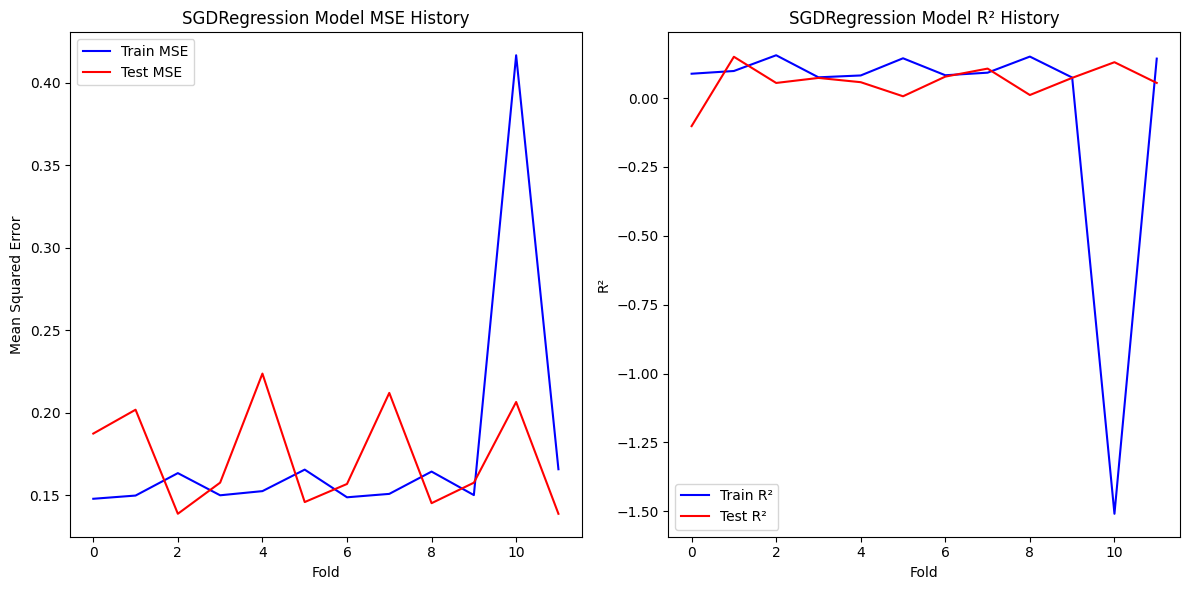

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_mse_train, label="Train MSE", color='blue')
plt.plot(history_mse_test, label="Test MSE", color='red')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title(f'SGDRegression Model MSE History')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_r2_train, label="Train R²", color='blue')
plt.plot(history_r2_test, label="Test R²", color='red')
plt.xlabel('Fold')
plt.ylabel('R²')
plt.title(f'SGDRegression Model R² History')
plt.legend()

plt.tight_layout()
plt.show()

# Top 20-features by weights

In [36]:
model = SGDRegressor(
                penalty='l2', 
                alpha=np.float64(0.23),
                max_iter=1000,
                tol=1e-3,
                random_state=42
            )
model.fit(X_train, y_train)

SGDRegressor(alpha=np.float64(0.23), random_state=42)

Coefficients data type: <class 'numpy.ndarray'>
Feature names data type: <class 'pandas.core.indexes.base.Index'>
Data types of feature_importance:
Feature        object
Importance    float64
dtype: object
First few rows of feature_importance:
           Feature  Importance
0       day_precip   -0.010646
1  day_precipcover   -0.004359
2         day_snow   -0.001122
3    day_windspeed    0.002068
4      day_winddir    0.002489
Any NaN values in Importance column? 0


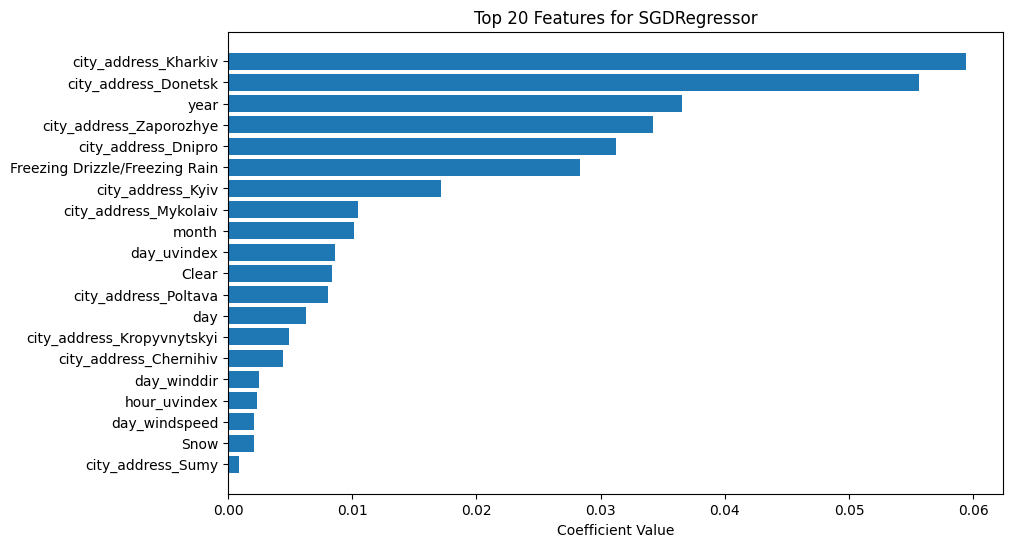

In [41]:
coefficients = model.coef_
feature_names = X_train.columns
print("Coefficients data type:", type(coefficients))
print("Feature names data type:", type(feature_names))

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})

print("Data types of feature_importance:")
print(feature_importance.dtypes)
print("First few rows of feature_importance:")
print(feature_importance.head())

feature_importance['Importance'] = pd.to_numeric(feature_importance['Importance'], errors='coerce')

print("Any NaN values in Importance column?", feature_importance['Importance'].isna().sum())

feature_importance = feature_importance.dropna(subset=['Importance'])

top_features = feature_importance.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Coefficient Value')
plt.title(f'Top 20 Features for SGDRegressor')
plt.gca().invert_yaxis()
plt.show()

In [46]:
model1 = SGDRegressor(
    penalty='l1', 
    alpha=0.23,
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    verbose=1  
)
model1.fit(X_train, y_train)
train_losses = []

for _ in range(model1.max_iter):
    model1.partial_fit(X_train, y_train)
    y_train_pred = model1.predict(X_train)
    loss = mean_squared_error(y_train, y_train_pred) 
    train_losses.append(loss)  


-- Epoch 1
Norm: 1.25, NNZs: 0, Bias: 0.209043, T: 456177, Avg. loss: 0.096756
Total training time: 0.19 seconds.
-- Epoch 1
Norm: 0.79, NNZs: 0, Bias: 0.208317, T: 456177, Avg. loss: 0.096742
Total training time: 0.19 seconds.
-- Epoch 1
Norm: 0.69, NNZs: 0, Bias: 0.207797, T: 456177, Avg. loss: 0.096741
Total training time: 0.19 seconds.
-- Epoch 1
Norm: 0.63, NNZs: 0, Bias: 0.207394, T: 456177, Avg. loss: 0.096739
Total training time: 0.19 seconds.
-- Epoch 1
Norm: 0.59, NNZs: 0, Bias: 0.207066, T: 456177, Avg. loss: 0.096739
Total training time: 0.19 seconds.
-- Epoch 1
Norm: 0.56, NNZs: 0, Bias: 0.206790, T: 456177, Avg. loss: 0.096738
Total training time: 0.19 seconds.
-- Epoch 1
Norm: 0.54, NNZs: 0, Bias: 0.206551, T: 456177, Avg. loss: 0.096738
Total training time: 0.18 seconds.
-- Epoch 1
Norm: 0.52, NNZs: 0, Bias: 0.206341, T: 456177, Avg. loss: 0.096737
Total training time: 0.18 seconds.
-- Epoch 1
Norm: 0.50, NNZs: 0, Bias: 0.206154, T: 456177, Avg. loss: 0.096737
Total tra

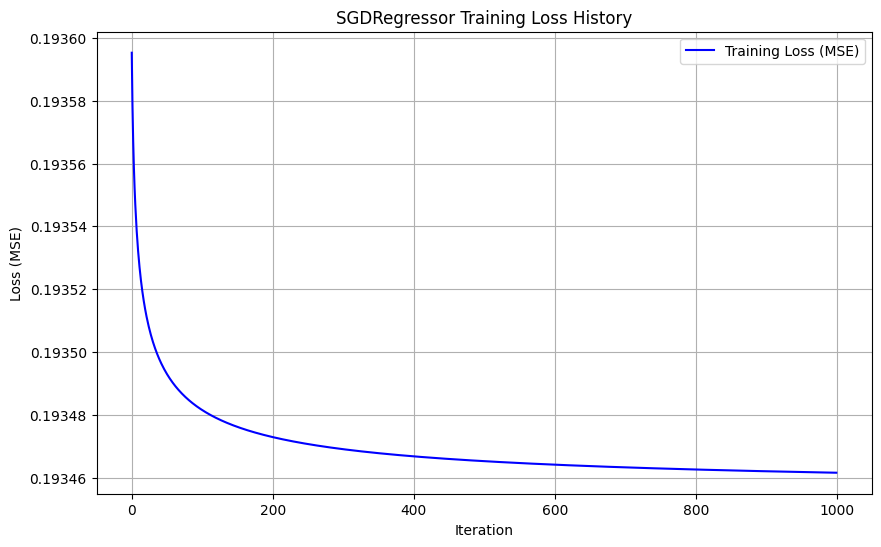

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss (MSE)', color='b')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('SGDRegressor Training Loss History')
plt.grid(True)
plt.legend()
plt.show()

In [49]:
model2 = SGDRegressor(
    penalty='l2', 
    alpha=0.23,
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    verbose=1  
)
model2.fit(X_train, y_train)

train_losses = []

for _ in range(model2.max_iter):
    model1.partial_fit(X_train, y_train)
    y_train_pred = model2.predict(X_train)
    loss = mean_squared_error(y_train, y_train_pred) 
    train_losses.append(loss)  


-- Epoch 1
Norm: 6172098331.44, NNZs: 53, Bias: -48080924.081188, T: 456177, Avg. loss: 25692132219458736128.000000
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 13483183723.44, NNZs: 53, Bias: 83321393.843590, T: 912354, Avg. loss: 92801380323681583104.000000
Total training time: 0.20 seconds.
-- Epoch 3
Norm: 14311871104.33, NNZs: 53, Bias: -171110254.418745, T: 1368531, Avg. loss: 64516423008142532608.000000
Total training time: 0.30 seconds.
-- Epoch 4
Norm: 4161759010.34, NNZs: 53, Bias: 88180604.548483, T: 1824708, Avg. loss: 46727254780323954688.000000
Total training time: 0.40 seconds.
-- Epoch 5
Norm: 115963288.93, NNZs: 53, Bias: -1933655.227628, T: 2280885, Avg. loss: 41003410366833975296.000000
Total training time: 0.51 seconds.
-- Epoch 6
Norm: 45245725.76, NNZs: 53, Bias: 431553.432821, T: 2737062, Avg. loss: 32234628928230828.000000
Total training time: 0.61 seconds.
-- Epoch 7
Norm: 668845.95, NNZs: 53, Bias: -5539.335257, T: 3193239, Avg. loss: 9930980758867394.0

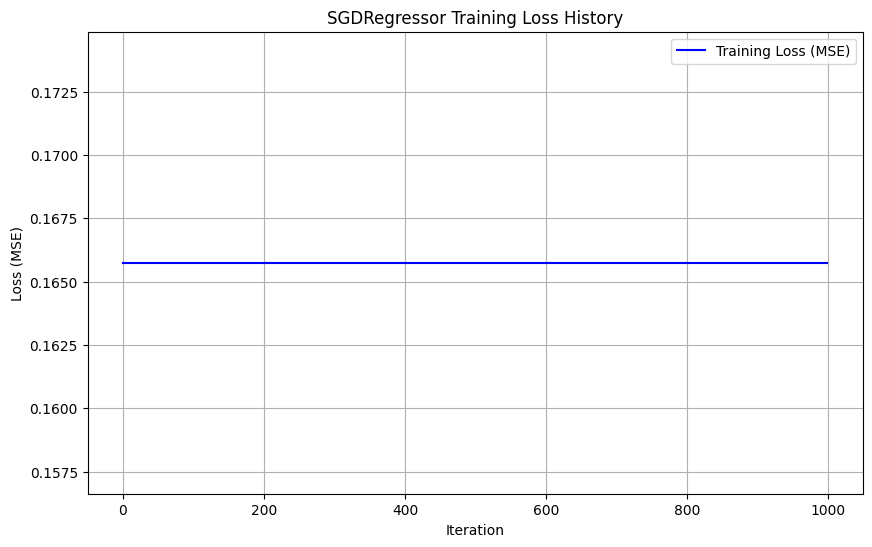

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss (MSE)', color='b')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.title('SGDRegressor Training Loss History')
plt.grid(True)
plt.legend()
plt.show()